# Simple acoustic wave 2D

In this tutorial, we demonstrate how to simulate acoustic wave propagation in 2D domain using pywave.

First, we define the number of points and the grid spacing (in meters) in each dimension.

In [1]:
from pywave import *
import numpy as np

# number of grid points (z,x)
shape = (512, 512)

# spacing (in meters)
spacing = (15.0, 15.0)

# propagation time (miliseconds)
time = 2000

Next, the velocity model is created. In this example we create a velocity model with two velocity values and stores the data in a numpy array. 

In [2]:
# Velocity model
vel = np.zeros(shape, dtype=np.float32)
vel[:] = 1500.0
vel[256:] = 2500.0
velModel = Model(ndarray=vel)

A second method can read a model from an existing file using the SEGY format in 2D (3D to be implemented):

`velModel = Model(file="path/to/segy_file")`

The velocity model can be ploted as follows.

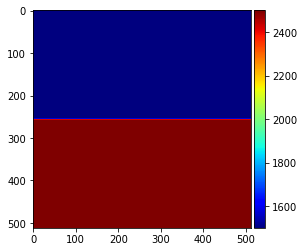

Velocity model saved in plots/velocity_model.png


In [3]:
plot_velocity_model(velModel, show=True)

Now some compiler options are set.

In [4]:
# Compiler
compiler = Compiler(cc="gcc", cflags="-O3 -shared") 

The domain can be extended with an absorbing layer and spatial order halo. At this point some parameters can be defined:

    nbl : {sequence, int}, optional
        Number of grid points (boundary layers) padded to the edges of each axis (Z,X,[Y]).
        ((before_1, after_1), … (before_N, after_N)) unique pad widths for each side of each axis.
        Int is a shortcut for before = after for all axes.
        Default is 0 points.
    boundary_condition : {sequence, str}
        Boundary condition implementation on the edges of each axis (Z,X,[Y]).
        ((before_1, after_1), … (before_N, after_N)) unique boundary condition for each side of each axis.
        Str is a shortcut for before = after width for all axes.
        Available options include: 'NN' (null neumann), 'ND' (null dirichlet) and 'N' (none).
        Default is N (no boundaray condition).
    damping_polynomial_degree : int, optional
        Degree of the polynomial in the extension function.
        Default is 1 (linear)
    alpha : float, optional
        Constant parameter of the extension function.
        Default is 0.0001

Implementation notes:

Absorbing layer is implemented with damping. The damping factor ($\eta$) is zero inside the original domain, while in the extended region it grows linearly:

$\eta(z,x) = \alpha d(z,x)^e$, 

where:

**d** is the perpendicular distance from the point $(z, x)$ to the boundary between original and extended domain;

**e** is a polynomial degree (we used cubic in this example).

More details in: **Y. Gao et al. Comparison of artificial absorbing boundaries for acoustic wave equation modelling, Exploration Geophysics (2017) 76–93.** 

In [5]:
# domain extension (damping, boundary conditions, halo)
extension = BoundaryProcedures(
    nbl=((0, 50), (50, 50)), # damping (with 50 grid points) on the left, right and bottom. There is no damping on the top
    boundary_condition=(("NN", "ND"), ("ND", "ND")), #dirichlet on the left, right and bottom, neumann on the top
    damping_polynomial_degree=3,
    alpha=0.0001,
)

Next, define the source wavelet. Parameters include frequency and amplitude. So far, pywave implements only the Ricker source. 

In [6]:
# Wavelet
wavelet = Wavelet(frequency=5.0)

The class `Source` encapsulates a set of sources that behave according to the `wavelet`. An arbitraty number of sources can be added by the `_.add(position=(z,x))` method wich receives the position in grid points. 
Interpolation is made as described in **Hicks, Graham J. "Arbitrary source and receiver positioning in finite-difference schemes using Kaiser windowed sinc functions." Geophysics 67.1 (2002): 156-165.**
The parameter `kws_half_width` defines the radius of the Kaiser window for the source interpolation. 

In [7]:
# Source
source = Source(kws_half_width=1, wavelet=wavelet)
source.add(position=(30,255.5))

Receivers are defined in a similar way:

In [8]:
# receivers
receivers = Receiver(kws_half_width=1)

for i in range(512):
    receivers.add(position=(15.5,i))

Next, set some configuration parameters for the solver, including:

    velocity_model : object
        Velocity model object.
    sources : object
        Object that represents the set of sources.
    receivers : object
        Object that represents the set of receivers.
    boundary_config : object
        Object that holds the domain extension configuration.
    spacing : tuple(int,...)
        Spacing along each axis.
    progatation_time : int
        Propagation time in miliseconds.
    space_order : int, optional
        Define spatial order. Defaut is 2.
    jumps : int, optional
        Skipping factor when saving the wavefields. If jumps is 0, only the last wavefield is saved. Default is 0.
    compiler : object, optional
        Object that represents the compiler.
    density: object, optional
        Density model object.

In [9]:
setup = Setup(
    velocity_model=velModel,
    sources=source,
    receivers=receivers,
    boundary_config=extension,
    spacing=spacing,
    propagation_time=time,
    jumps=1,
    compiler=compiler,
    space_order=2,
)

solver = AcousticSolver(setup=setup)

wavefields, rec, exec_time = solver.forward()

Compilation command: gcc /home/jaime/Documentos/WORK/pywave/pywave/kernel/c_code/forward/multiple_space_order/constant_density/2d/sequential.c -O3 -shared -o /home/jaime/Documentos/WORK/pywave/tutorial/tmp/lib_c_wave.so
Model: Acoustic
Dimension: 2D
Shape: (471, 564, 614)
Spacing: (15.0, 15.0)
Density: constant
Space Order: 2
Propagation time: 2000 miliseconds 
DT: 0.004243 seconds
Frequency: 5.0 Hz
Timesteps: 471
Computing forward...


If we print the wavefields shape, we have the number of snapshots (equal to the number of timesteps), and the extendend grid.

- 471 timesteps
- 564 grid points in Z (512 original + 50 damping bottom + 2 space order halo)
- 614 grid points in X (512 original + 50 damping left + 50 damping right + 2 space order halo)


In [10]:
print(wavefields.shape)

(471, 564, 614)


Forward execution time: 2.824221 seconds


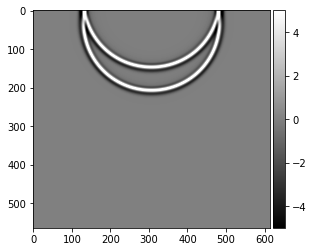

Wavefield saved in plots/wavefield.png


In [11]:
print("Forward execution time: %f seconds" % exec_time)

# plot the last snapshot
plot_wavefield(wavefields[-1], show=True)

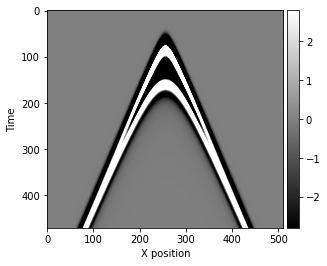

Shot record saved in plots/shotrecord.png


In [12]:
# plot the shot record
plot_shotrecord(rec, show=True)